In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense,LSTM
from sklearn import metrics
from datetime import timedelta, date, datetime
import time

We gather the NordPool dataset from the [NordPool](https://www.nordpoolgroup.com/ "NP") website. .We do not own the data, but we simply have gathered it so other researchers can easily test their methods on multiple day-ahead markets.

In [56]:
from google.colab import files
import io
uploaded = files.upload()

Saving NP.csv to NP (1).csv


In [74]:
#read dataframe from DB
df=pd.read_csv(io.BytesIO(uploaded['NP.csv']), index_col='Date', parse_dates=True, dayfirst = True)

df = df.sort_index()

#Handeling global outliers
GlobalOutliers =  []
for i in range(12):
    GlobalOutliers.append(df.idxmax()[' Price'])
    df.at[df.idxmax()[' Price'], ' Price'] = np.nan

#Replacing them with the mean of that day
for d in GlobalOutliers:
    sdt = datetime.combine(d, datetime.min.time())
    edt = sdt + timedelta(hours=24)
    df.at[d, ' Price'] = df[sdt:edt][' Price'].mean()
    
    
#Handling negative values 
negativeIndex = df.index[df[' Price'] < 0]
for index in (negativeIndex):
    df.at[index, ' Price']= df.at[index - timedelta(hours=1), ' Price']

df = df.dropna()

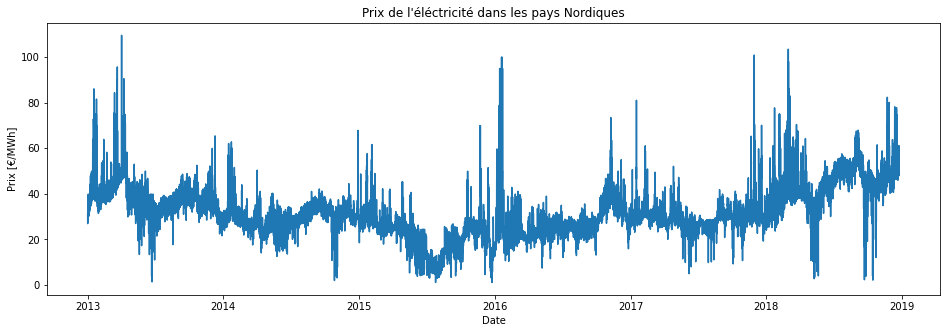

In [95]:
#Plot Prix PT after data cleaning
plt.figure(figsize=(16,5))
plt.gca().set(title="Prix de l'éléctricité dans les pays Nordiques", xlabel='Date', ylabel='Prix [€/MWh]')
plt.plot(df.index, df[' Price'])  
plt.show()

In [78]:
df_u=df[[' Price']].dropna()
df_u

,Price
Date,
2013-01-01 00:00:00,31.05
2013-01-01 01:00:00,30.47
2013-01-01 02:00:00,28.92
2013-01-01 03:00:00,27.88
2013-01-01 04:00:00,26.96
...,...
2018-12-24 19:00:00,50.72
2018-12-24 20:00:00,49.86
2018-12-24 21:00:00,49.09


In [79]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [80]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(df_u.values)
    
reframed= series_to_supervised(scaled, 14)
reframed

,var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
14,-0.448206,-0.458906,-0.487501,-0.506688,-0.523660,-0.507426,-0.489899,-0.492851,-0.496356,-0.498939,-0.455585,-0.438982,-0.427728,-0.422378,-0.419057
15,-0.458906,-0.487501,-0.506688,-0.523660,-0.507426,-0.489899,-0.492851,-0.496356,-0.498939,-0.455585,-0.438982,-0.427728,-0.422378,-0.419057,-0.400240
16,-0.487501,-0.506688,-0.523660,-0.507426,-0.489899,-0.492851,-0.496356,-0.498939,-0.455585,-0.438982,-0.427728,-0.422378,-0.419057,-0.400240,-0.377179
17,-0.506688,-0.523660,-0.507426,-0.489899,-0.492851,-0.496356,-0.498939,-0.455585,-0.438982,-0.427728,-0.422378,-0.419057,-0.400240,-0.377179,-0.352827
18,-0.523660,-0.507426,-0.489899,-0.492851,-0.496356,-0.498939,-0.455585,-0.438982,-0.427728,-0.422378,-0.419057,-0.400240,-0.377179,-0.352827,-0.344894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52411,-0.102297,-0.097685,-0.088460,-0.055622,-0.038465,-0.040679,-0.045476,-0.042708,-0.053224,-0.053593,-0.045291,-0.038465,-0.050457,-0.074993,-0.085324
52412,-0.097685,-0.088460,-0.055622,-0.038465,-0.040679,-0.045476,-0.042708,-0.053224,-0.053593,-0.045291,-0.038465,-0.050457,-0.074993,-0.085324,-0.101190
52413,-0.088460,-0.055622,-0.038465,-0.040679,-0.045476,-0.042708,-0.053224,-0.053593,-0.045291,-0.038465,-0.050457,-0.074993,-0.085324,-0.101190,-0.115395
52414,-0.055622,-0.038465,-0.040679,-0.045476,-0.042708,-0.053224,-0.053593,-0.045291,-0.038465,-0.050457,-0.074993,-0.085324,-0.101190,-0.115395,-0.116687


In [83]:
#values = reframed_differenced.values
values = reframed.values
n_train_days=  int(len(values) * 0.5)
n_val_days= int(len(values) * 0.75)
train = values[:n_train_days, :]
val= values[n_train_days:n_val_days, :]
test = values[n_val_days:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(test_X)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X= val_X.reshape((val_X.shape[0], 1,val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(test_X)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

index_test=df_u[' Price'][n_val_days:]

[[-0.56184854 -0.56387787 -0.56646066 ... -0.59136611 -0.59579375
  -0.60114381]
 [-0.56387787 -0.56646066 -0.56535375 ... -0.59579375 -0.60114381
  -0.60169726]
 [-0.56646066 -0.56535375 -0.56295545 ... -0.60114381 -0.60169726
  -0.60114381]
 ...
 [-0.08846047 -0.05562218 -0.03846509 ... -0.07499308 -0.08532423
  -0.10118993]
 [-0.05562218 -0.03846509 -0.0406789  ... -0.08532423 -0.10118993
  -0.11539526]
 [-0.03846509 -0.0406789  -0.04547551 ... -0.10118993 -0.11539526
  -0.11668665]]
[[[-0.56184854 -0.56387787 -0.56646066 ... -0.59136611 -0.59579375
   -0.60114381]]

 [[-0.56387787 -0.56646066 -0.56535375 ... -0.59579375 -0.60114381
   -0.60169726]]

 [[-0.56646066 -0.56535375 -0.56295545 ... -0.60114381 -0.60169726
   -0.60114381]]

 ...

 [[-0.08846047 -0.05562218 -0.03846509 ... -0.07499308 -0.08532423
   -0.10118993]]

 [[-0.05562218 -0.03846509 -0.0406789  ... -0.08532423 -0.10118993
   -0.11539526]]

 [[-0.03846509 -0.0406789  -0.04547551 ... -0.10118993 -0.11539526
   -0.1166

In [84]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

filepath ='models/MODEL.hdf5'

callbacks = [EarlyStopping(monitor='val_loss',patience=50),
            ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min')]

In [85]:
# fit network
start_time=time.time()
history = model.fit(train_X, train_y, epochs=100, batch_size=20, callbacks=callbacks, validation_data=(val_X, val_y), shuffle=False)
exec_time= time.time()-start_time

Epoch 1/100
1311/1311 [==============================] - 13s 5ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 2/100
1311/1311 [==============================] - 6s 4ms/step - loss: 0.0013 - val_loss: 0.0019
Epoch 3/100
1311/1311 [==============================] - 6s 4ms/step - loss: 0.0011 - val_loss: 0.0018
Epoch 4/100
1311/1311 [==============================] - 6s 5ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 5/100
1311/1311 [==============================] - 6s 4ms/step - loss: 9.5122e-04 - val_loss: 0.0016
Epoch 6/100
1311/1311 [==============================] - 6s 5ms/step - loss: 9.1182e-04 - val_loss: 0.0016
Epoch 7/100
1311/1311 [==============================] - 6s 4ms/step - loss: 8.8952e-04 - val_loss: 0.0016
Epoch 8/100
1311/1311 [==============================] - 6s 5ms/step - loss: 8.7458e-04 - val_loss: 0.0016
Epoch 9/100
1311/1311 [==============================] - 8s 6ms/step - loss: 8.6217e-04 - val_loss: 0.0016
Epoch 10/100
1311/1311 [============================

In [86]:
model.load_weights("models/MODEL.hdf5")

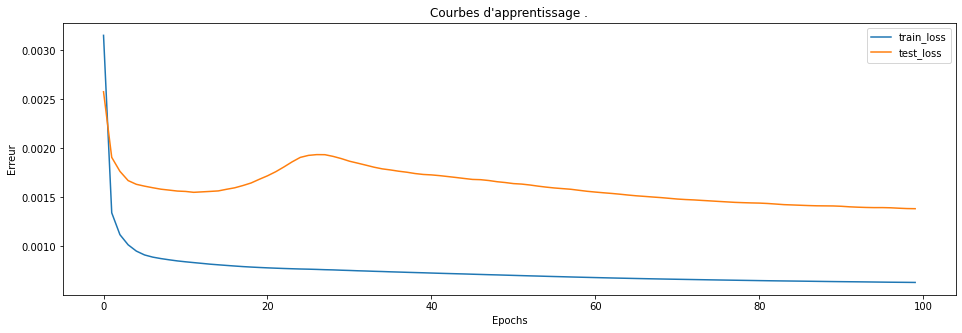

In [87]:
# plot history
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.gca().set(title='Courbes d\'apprentissage .', xlabel='Epochs', ylabel='Erreur')
plt.legend()

In [88]:
# make a prediction
print(test_X.shape)
yhat = model.predict(test_X)
#Transform test to be 2D
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

(13101, 1, 14)


In [89]:
test_X=pd.DataFrame(test_X)
# invert scaling for forecast
test_X[0]= yhat
inv_yhat = scaler.inverse_transform(test_X)
inv_yhat = inv_yhat[:,0]

In [90]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
test_X[0]= test_y
inv_y = scaler.inverse_transform(test_X)
inv_y = inv_y[:,0]

In [91]:
#Calculate MAE, MSE, RMSE, CV
MAE= metrics.mean_absolute_error(inv_y, inv_yhat)
MSE=metrics.mean_squared_error(inv_y, inv_yhat)
CV= (np.sqrt(metrics.mean_squared_error(inv_y, inv_yhat))/inv_y.mean())*100
R2= metrics.r2_score(inv_y, inv_yhat)

print('Mean Absolute Error:', MAE)
print('Mean Squared Error:', MSE)  
print('Root Mean Squared Error:', np.sqrt(MSE))
print('Coefficient of Variance:',CV)
print('R2:', R2)
print('exec_time:', exec_time)

Mean Absolute Error: 1.6534077272361971
Mean Squared Error: 7.0506243151666625
Root Mean Squared Error: 2.6553011722150583
Coefficient of Variance: 6.829053968272936
R2: 0.9412958474993807
exec_time: 622.2484719753265


[Text(0, 0.5, 'Price [€/MWh]'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, "Prix de l'éléctricité dans les pays Nordiques")]

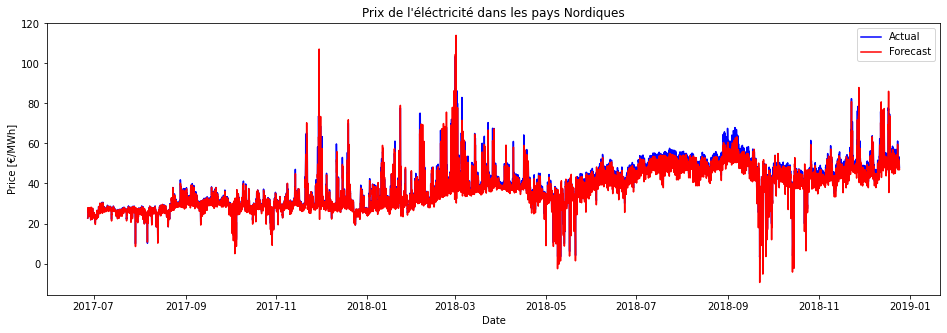

In [92]:
plt.figure(figsize=(16,5))
plt.plot(index_test[14:].index, inv_y, color='blue')
plt.plot(index_test[14:].index, inv_yhat, color='red')
plt.legend(('Actual', 'Forecast'))
plt.gca().set(title="Prix de l'éléctricité dans les pays Nordiques", xlabel='Date', ylabel='Price [€/MWh]')

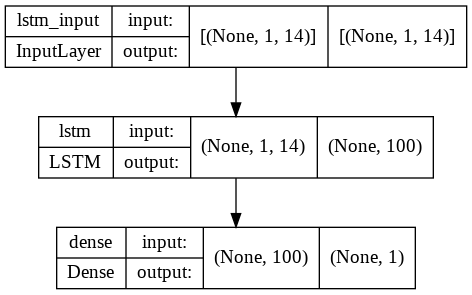

In [93]:
plot_model(model, show_shapes=True, show_layer_names=True )

In [ ]:
# BEST n_in

score = []
best_n = 1
best_score = 0

for n in range(best_n, 30):
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaled = scaler.fit_transform(df_u.values)
  reframed= series_to_supervised(scaled, n)
  
  #values = reframed_differenced.values
  values = reframed.values
  n_train_days=  int(len(values) * 0.5)
  n_val_days= int(len(values) * 0.75)
  train = values[:n_train_days, :]
  val= values[n_train_days:n_val_days, :]
  test = values[n_val_days:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  val_X, val_y = val[:, :-1], val[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  val_X= val_X.reshape((val_X.shape[0], 1,val_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  index_test=df_u['Price - PT [€/MWh]'][n_val_days:]
    # design network
  model = Sequential()
  model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  # fit network
  start_time=time.time()
  history = model.fit(train_X, train_y, epochs=200, batch_size=100, validation_data=(val_X, val_y), verbose=0, shuffle=False)
  exec_time= time.time()-start_time
  # make a prediction
  
  yhat = model.predict(test_X)
  #Transform test to be 2D
  test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
  test_X=pd.DataFrame(test_X)
  # invert scaling for forecast
  test_X[0]= yhat
  inv_yhat = scaler.inverse_transform(test_X)
  inv_yhat = inv_yhat[:,0]
  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  test_X[0]= test_y
  inv_y = scaler.inverse_transform(test_X)
  inv_y = inv_y[:,0]
  #Calculate MAE, MSE, RMSE, CV
  MAE= metrics.mean_absolute_error(inv_y, inv_yhat)
  MSE=metrics.mean_squared_error(inv_y, inv_yhat)
  CV= (np.sqrt(metrics.mean_squared_error(inv_y, inv_yhat))/inv_y.mean())*100
  R2= metrics.r2_score(inv_y, inv_yhat)
  print(n)

  print('Mean Absolute Error:', MAE)
  print('Mean Squared Error:', MSE)  
  print('Root Mean Squared Error:', np.sqrt(MSE))
  print('Coefficient of Variance:',CV)
  print('R2:', R2)
  print('exec_time:', exec_time)
  print("*************************")



  if best_score < R2:
        best_n = n
print('best_n' , best_n)